## Moving Average Model (MA)

In [1]:
import pandas as pd

df_sales = pd.read_csv("data/widget_sales.csv")
df_sales.head()

,widget_sales
0,50.496714
1,50.805493
2,51.477758
3,53.542228
4,54.873108


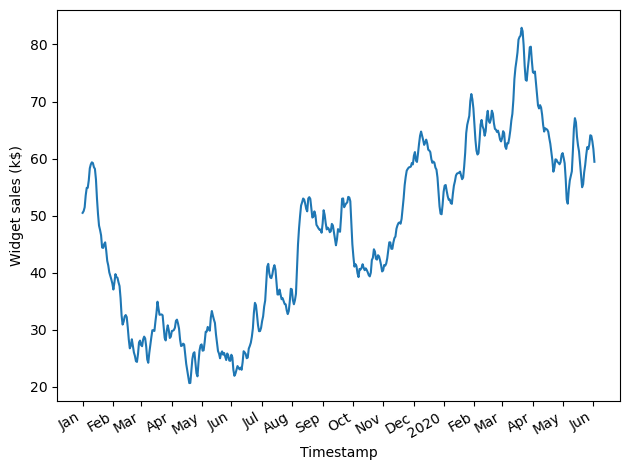

In [2]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(df_sales["widget_sales"])
ax.set_xlabel("Timestamp")
ax.set_ylabel("Widget sales (k$)")

plt.xticks([0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498],
           ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec", "2020", "Feb", "Mar", "Apr", "May", "Jun"])
fig.autofmt_xdate()
plt.tight_layout()

In [3]:
# Test stationarity
from statsmodels.tsa.stattools import adfuller

ADF_result = adfuller(df_sales["widget_sales"])

print(f"ADF statistics: {ADF_result[0]}")
print(f"p-value: {ADF_result[1]}")

ADF statistics: -1.5121662069359048
p-value: 0.5274845352272605


In [4]:
# Make timeseries stationary

import numpy as np

stationary_widgets_sales = np.diff(df_sales["widget_sales"], n=1)

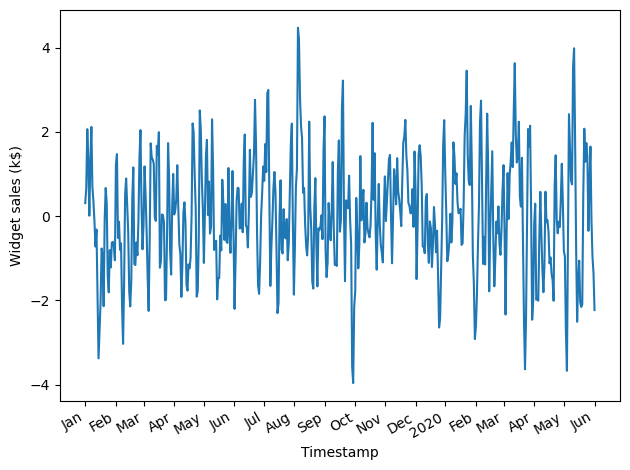

In [5]:
# Plot new stationary widgets sales

fig, ax = plt.subplots()

ax.plot(stationary_widgets_sales)
ax.set_xlabel("Timestamp")
ax.set_ylabel("Widget sales (k$)")

plt.xticks([0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498],
           ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec", "2020", "Feb", "Mar", "Apr", "May", "Jun"])
fig.autofmt_xdate()
plt.tight_layout()

In [6]:
# Again test for stationarity

new_adf_result = adfuller(stationary_widgets_sales)

print(f"ADF statistics: {new_adf_result[0]}")
print(f"p-value: {new_adf_result[1]}")

ADF statistics: -10.576657780341959
p-value: 7.076922818587193e-19


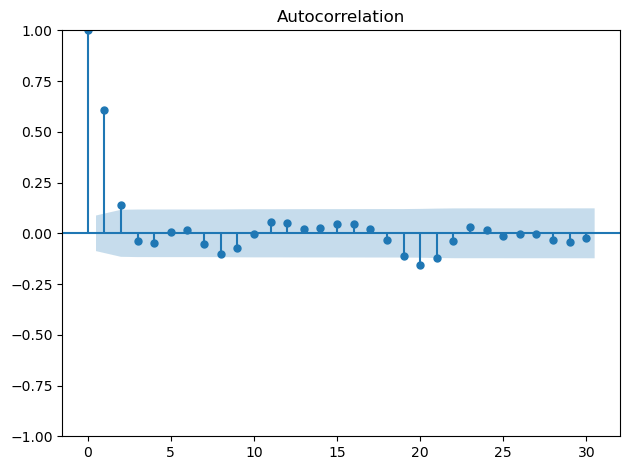

In [7]:
# Plot ACF

from statsmodels.graphics.tsaplots import plot_acf

plot_acf(stationary_widgets_sales, lags=30)

plt.tight_layout()

### Forecasting MA

In [8]:
df_stationary_sales = pd.DataFrame({"widget_sales_diff": stationary_widgets_sales})

train_data = df_stationary_sales[:int(0.9 * len(df_stationary_sales))]
test_data = df_stationary_sales[int(0.9 * len(df_stationary_sales)):]

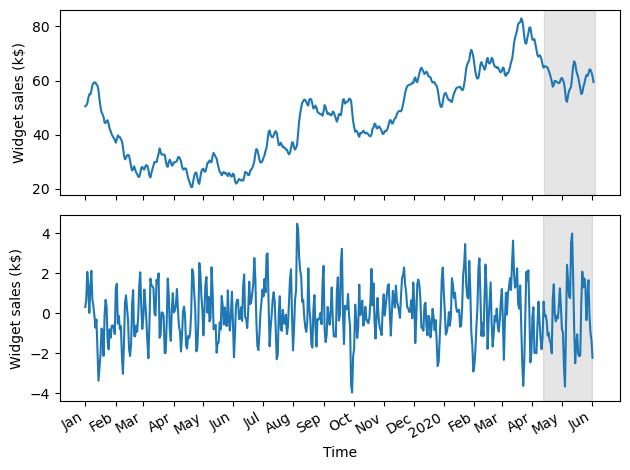

In [9]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

ax1.plot(df_sales["widget_sales"])
ax1.set_xlabel("Time")
ax1.set_ylabel("Widget sales (k$)")
ax1.axvspan(450, 500, color="#808080", alpha=0.2)

ax2.plot(df_stationary_sales["widget_sales_diff"])
ax2.set_xlabel("Time")
ax2.set_ylabel("Widget sales (k$)")
ax2.axvspan(449, 498, color="#808080", alpha=0.2)

plt.xticks([0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498],
           ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec", "2020", "Feb", "Mar", "Apr", "May", "Jun"])
fig.autofmt_xdate()
plt.tight_layout()

In [10]:
# Use rolling forecast

from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:

    total_len = train_len + horizon

    if method == "mean":

        pred_mean = []

        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean
    
    elif method == "last":

        pred_last_val = []
        for i in range(train_len, total_len, window):
            last_val = df[:i].iloc[-1].values[0]
            pred_last_val.extend(last_val for _ in range(window))

        return pred_last_val
    
    elif method == "MA":

        pred_ma = []
        
        for i in range(train_len, total_len, window):

            model = SARIMAX(df[:i], order=(0, 0, 2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ma.extend(oos_pred)

        return pred_ma


In [11]:
pred_df = test_data.copy()

TRAIN_LEN = len(train_data)
HORIZON = len(test_data)
WINDOW = 2

pred_mean = rolling_forecast(df_stationary_sales, TRAIN_LEN, HORIZON, WINDOW, "mean")
pred_last = rolling_forecast(df_stationary_sales, TRAIN_LEN, HORIZON, WINDOW, "last")
pred_MA = rolling_forecast(df_stationary_sales, TRAIN_LEN, HORIZON, WINDOW, "MA")

pred_df["pred_mean"] = pred_mean
pred_df["pred_last"] = pred_last
pred_df["pred_MA"] = pred_MA

pred_df.head()


,widget_sales_diff,pred_mean,pred_last,pred_MA
449,-1.170131,0.034319,-1.803658,-1.078833
450,0.580967,0.034319,-1.803658,-0.273309
451,-0.144902,0.032861,0.580967,0.781223
452,-0.096564,0.032861,0.580967,0.234969
453,-0.372334,0.032183,-0.096564,0.168994


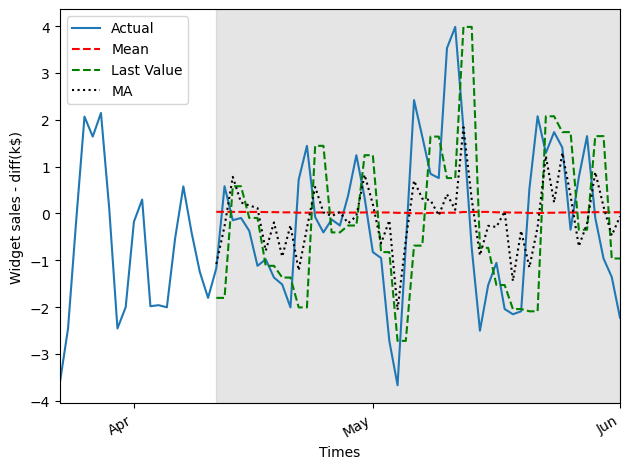

In [12]:
# Plot new stationary widgets sales

fig, ax = plt.subplots()

ax.plot(df_stationary_sales["widget_sales_diff"].iloc[430:], label="Actual")
ax.plot(pred_df["pred_mean"], "r--", label="Mean")
ax.plot(pred_df["pred_last"], "g--", label="Last Value")
ax.plot(pred_df["pred_MA"], "k:", label="MA")
ax.set_xlabel("Times")
ax.set_ylabel("Widget sales - diff(k$)")
ax.axvspan(449, 498, color="#808080", alpha=0.2)
ax.legend(loc=2)
ax.set_xlim(430, 498)

plt.xticks([439, 468, 498],
           ["Apr", "May", "Jun"])

fig.autofmt_xdate()
plt.tight_layout()

In [13]:
# Calculate metrics

from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(pred_df["widget_sales_diff"], pred_df["pred_mean"])
mse_last = mean_squared_error(pred_df["widget_sales_diff"], pred_df["pred_last"])
mse_MA = mean_squared_error(pred_df["widget_sales_diff"], pred_df["pred_MA"])

print(mse_mean, mse_last, mse_MA)

2.5606299456880537 3.2494260812249225 1.9481714497559062


In [14]:
# Obtain predictions in original dataset

df_sales["pred_widget_sales"] = pd.Series()
df_sales["pred_widget_sales"][450:] = df_sales["widget_sales"].iloc[450] + pred_df["pred_MA"].cumsum()

/tmp/ipykernel_29091/4031578644.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sales["pred_widget_sales"][450:] = df_sales["widget_sales"].iloc[450] + pred_df["pred_MA"].cumsum()


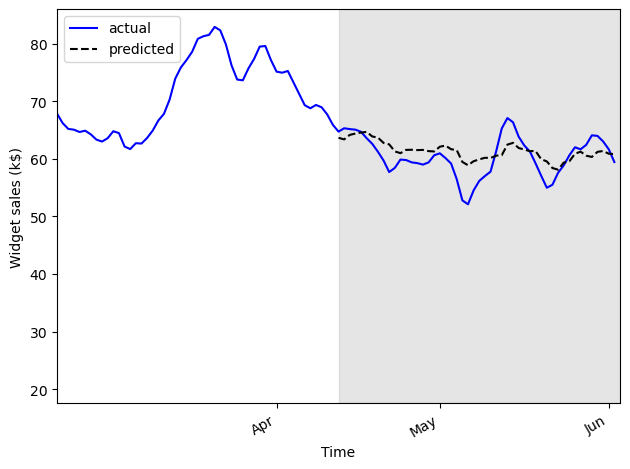

In [15]:
fig, ax = plt.subplots()

ax.plot(df_sales["widget_sales"], "b-", label="actual")
ax.plot(df_sales["pred_widget_sales"], "k--", label="predicted")

ax.legend(loc=2)

ax.set_xlabel("Time")
ax.set_ylabel("Widget sales (k$)")

ax.axvspan(450, 500, color="#808080", alpha=0.2)
ax.set_xlim(400, 500)
plt.xticks([439, 468, 498],
           ["Apr", "May", "Jun"])

fig.autofmt_xdate()
plt.tight_layout()

In [16]:
# Evaluate model with mean absolute error (MAE) metric

from sklearn.metrics import mean_absolute_error

mae_MA = mean_absolute_error(df_sales["widget_sales"].iloc[450:], df_sales["pred_widget_sales"].iloc[450:])

mae_MA

2.3244709246094026

## Exercises

### Exercise 1 - simulate an MA(2) process and make forecast

In [17]:
from statsmodels.tsa.arima_process import ArmaProcess
import numpy as np

np.random.seed(11)

ma2 = np.array([1, 0.9, 0.3])
ar2 = np.array([1, 0, 0])

MA2_process = ArmaProcess(ar2, ma2).generate_sample(nsample=1000)

In [18]:
MA2_process

array([ 1.74945474e+00,  1.28843627e+00, -2.17194407e-01, -3.17524908e+00,
       -2.54164087e+00, -1.12308310e+00, -8.26782978e-01, -2.63453167e-01,
        5.43924309e-01, -5.92036535e-01, -1.71896714e+00, -1.59303009e+00,
       -4.34973420e-03,  1.03918621e+00, -5.93570858e-01, -2.12611127e+00,
       -6.62354897e-01,  1.90194515e+00,  1.60714679e+00, -2.39023985e-01,
        4.71205207e-01,  4.71456103e-01,  7.75822161e-01,  2.10937564e+00,
        2.24196996e+00,  1.10528657e+00,  9.87439214e-01,  3.85167972e-02,
       -5.36729622e-01, -9.27011035e-01, -7.74362372e-01, -8.42619252e-01,
       -6.84933509e-01, -6.93682738e-01, -3.09237737e-01,  2.95906082e-02,
        3.80344894e-01,  1.68858502e+00, -1.95464428e-01,  3.24273610e-01,
        4.64747510e-01, -1.05718603e+00, -1.35270649e+00, -4.33043278e-01,
        1.09848706e+00, -7.32803245e-02, -4.17855258e-01, -5.05744295e-03,
       -1.51286888e+00, -2.66610922e+00, -9.72311001e-01,  8.79932481e-01,
        1.89375199e+00,  

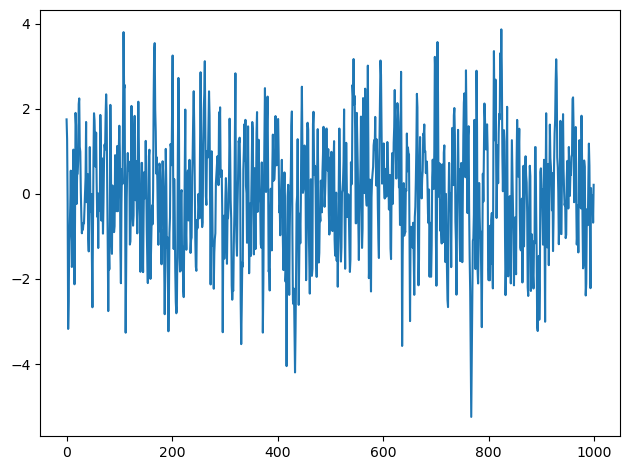

In [19]:
fig, ax = plt.subplots()

ax.plot(MA2_process, label="MA_process")

plt.tight_layout()

In [21]:
from statsmodels.tsa.stattools import adfuller

ADF_test = adfuller(MA2_process)

print(f"ADF statistics: {ADF_test[0]}")
print(f"p-value: {ADF_test[1]}")


ADF statistics: -13.828606965010477
p-value: 7.666544641354147e-26


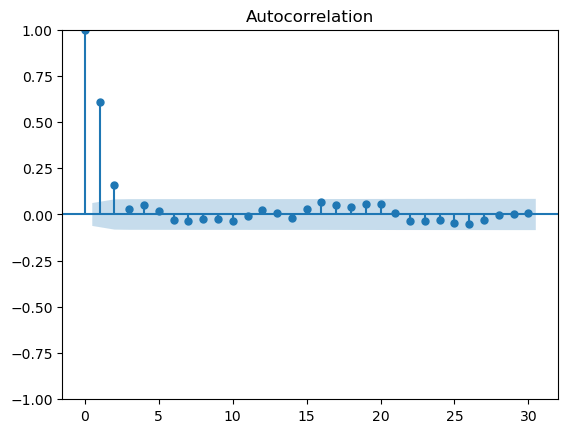

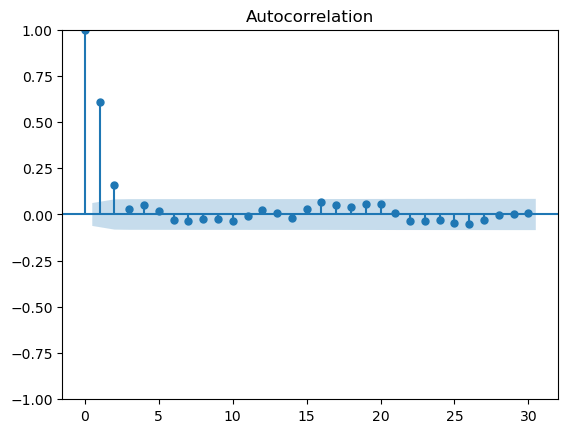

In [26]:
from statsmodels.graphics.tsaplots  import plot_acf

plot_acf(MA2_process, lags=30)

In [28]:
ma2_df = pd.DataFrame({
    "values": MA2_process
})

In [29]:
training_data = ma2_df.iloc[:800]
testing_data = ma2_df.iloc[800:]

In [30]:
pred_df_ma2 = testing_data.copy()

TRAIN_LEN = len(training_data)
HORIZON = len(testing_data)
WINDOW = 2

pred_mean = rolling_forecast(ma2_df, TRAIN_LEN, HORIZON, WINDOW, "mean")
pred_last = rolling_forecast(ma2_df, TRAIN_LEN, HORIZON, WINDOW, "last")
pred_MA = rolling_forecast(ma2_df, TRAIN_LEN, HORIZON, WINDOW, "MA")

pred_df_ma2["pred_mean"] = pred_mean
pred_df_ma2["pred_last"] = pred_last
pred_df_ma2["pred_MA"] = pred_MA

pred_df_ma2.head()


,values,pred_mean,pred_last,pred_MA
800,-2.030170,-0.005584,-1.768256,-1.867210
801,-1.632110,-0.005584,-1.768256,-0.656300
802,-2.032562,-0.010136,-1.632110,-0.796601
803,-0.748676,-0.010136,-1.632110,-0.260442
804,-1.642674,-0.013571,-0.748676,0.174545


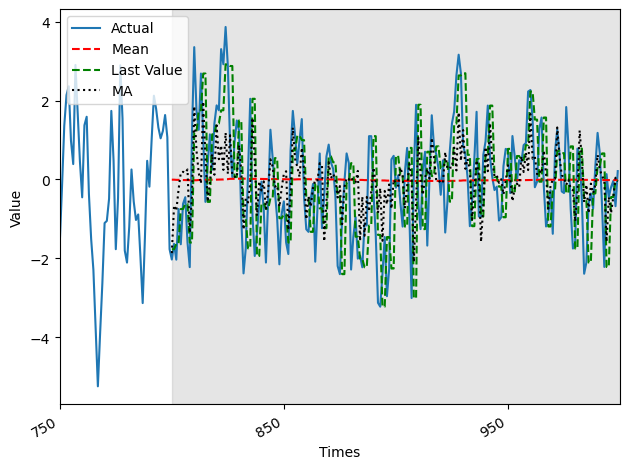

In [32]:
# Plot forecast of MA(2) model

fig, ax = plt.subplots()

ax.plot(ma2_df["values"].iloc[430:], label="Actual")
ax.plot(pred_df_ma2["pred_mean"], "r--", label="Mean")
ax.plot(pred_df_ma2["pred_last"], "g--", label="Last Value")
ax.plot(pred_df_ma2["pred_MA"], "k:", label="MA")
ax.set_xlabel("Times")
ax.set_ylabel("Value")
ax.axvspan(800, 1000, color="#808080", alpha=0.2)
ax.legend(loc=2)
ax.set_xlim(750, 1000)

plt.xticks([750, 850, 950],
           ["750", "850", "950"])

fig.autofmt_xdate()
plt.tight_layout()

In [33]:
# Calculate metrics

from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(pred_df_ma2["values"], pred_df_ma2["pred_mean"])
mse_last = mean_squared_error(pred_df_ma2["values"], pred_df_ma2["pred_last"])
mse_MA = mean_squared_error(pred_df_ma2["values"], pred_df_ma2["pred_MA"])

print(mse_mean, mse_last, mse_MA)

1.914330477381907 2.2356736979788656 1.4652484279450886


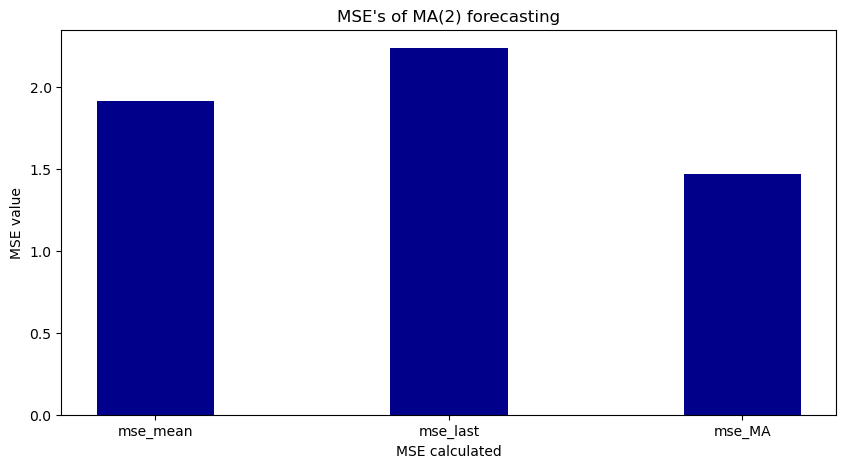

In [38]:
preds = ["mse_mean", "mse_last", "mse_MA"]
values = [mse_mean, mse_last, mse_MA]
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(preds, values, color ='darkblue', 
        width = 0.4)
 
plt.xlabel("MSE calculated")
plt.ylabel("MSE value")
plt.title("MSE's of MA(2) forecasting")
plt.show()